White Helmets
- Prepare data

To get a better understanding of our data you asked us to create 3 new datasets from the original ones by randomizing certain features. This technique is called Null Models, we've talked about it for P3, and it was talked about in the paper "The structure and function of antagonistic ties in village social networks" by Amir Ghasemian and Nicholas A. Christakis.
The Null Models are to identify what properties of the real network are significant and not due to hazard. Since the null models are generated by randomizing a feature but keeping the rest intact, some properties of the original dataset might disapear. So these are the significant properties that will help us understand what are the rules of our real network(hence, not an organic network but one constructeed by the propaganda machine of the WH).

- Extract network 
  
So for both twitter and facebook datasets, we now have 4 datasets. From these we extract the same type of graph that for the first assignement, nodes are users and there is an edge present is they interacted on the same video with a time interval of less than 52 seconds. Here we have a tuning parameter for the network, the time delta we're using. This 52 seconds rule suppose it's less than the time a human needs to see that there is a new post, whatch the video, and THEN also interact with it. So 52s is a good threshold to detect bot activities, that would automatically repost the video for instance. 
But if we're facing human coordinated activities, maybe that this threshold is too short to detect all the potential activity. If we increase it, we face the risk of including real human interaction. So there is a trade off here that can be used for the analysis.

- Compare networks



In [14]:
import pandas as pd
import networkx as nx
from datetime import timedelta
import matplotlib.pyplot as plt
import community as community_louvain

def extract_network(df, time_threshold=52):
    """
    Construit un graphe non dirigé où les noeuds sont les utilisateurs.
    Une arête est créée entre deux utilisateurs s'ils ont posté la même vidéo
    à moins de 'time_threshold' secondes d'écart.
    
    Args:
        df (pd.DataFrame): Le dataframe contenant les colonnes 'nodeUserID', 'videoID', 'nodeTime'.
        time_threshold (int): L'écart maximal en secondes (défaut: 52s).
        
    Returns:
        nx.Graph: Le graphe des interactions.
    """
    
    # 1. Initialisation du graphe
    G = nx.Graph()
    
    # Ajouter tous les utilisateurs comme noeuds (même ceux isolés)
    all_users = df['nodeUserID'].unique()
    #print(f"Nombre d'utilisateurs uniques: {len(all_users)}")
    G.add_nodes_from(all_users)
    
    # 2. Préparation des données
    # On s'assure que le temps est bien au format datetime pour les calculs
    df['nodeTime'] = pd.to_datetime(df['nodeTime'])
    
    # 3. Algorithme de détection des liens
    # On groupe par vidéo car les interactions ne se font qu'autour d'un même contenu
    grouped = df.groupby('videoID')
    
    edge_list = []
    
    for video_id, group in grouped:
        # S'il n'y a qu'un seul post pour cette vidéo, pas de lien possible
        if len(group) < 2:
            continue
            
        # On trie par temps pour optimiser la recherche (fenêtre glissante)
        group = group.sort_values('nodeTime')
        
        # On convertit en liste pour itérer plus vite qu'avec pandas pur
        users = group['nodeUserID'].tolist()
        times = group['nodeTime'].tolist()
        n = len(users)
        
        # Double boucle optimisée : on s'arrête dès que l'écart dépasse 52s
        for i in range(n):
            for j in range(i + 1, n):
                # Calcul du delta en secondes
                delta = (times[j] - times[i]).total_seconds()
                
                if delta <= time_threshold:
                    # Si c'est deux utilisateurs différents, on crée un lien
                    if users[i] != users[j]:
                        # On ajoute le lien. NetworkX gère les doublons automatiquement 
                        # (si A et B interagissent 2 fois, ça reste une seule arête simple ici.
                        # Pour un Multigraph ou pondéré, il faudrait changer cette ligne).
                        edge_list.append((users[i], users[j]))
                else:
                    # Puisque la liste est triée, si times[j] est trop loin, 
                    # tous les suivants (j+1, j+2...) le seront aussi. On break.
                    break
    
    # 4. Ajout massif des arêtes (plus rapide que one-by-one)
    G.add_edges_from(edge_list)
    
    return G

# Print network overviews with two different layouts
def plot_network_overview(G, title):
    """Plot network with both spring and circular layout side by side"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Spring Layout
    pos_spring = nx.spring_layout(G, seed=42)
    nx.draw(G, pos_spring, ax=axes[0], node_size=20, node_color='blue', 
            edge_color='gray', alpha=0.7)
    axes[0].set_title(f"{title}\n(Spring Layout)")
    axes[0].axis('off')
    
    # Circular Layout
    pos_circular = nx.circular_layout(G)
    nx.draw(G, pos_circular, ax=axes[1], node_size=20, node_color='blue', 
            edge_color='gray', alpha=0.7)
    axes[1].set_title(f"{title}\n(Circular Layout)")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_network_metrics(G, name="Réseau"):
    """
    Calcule et affiche les métriques clés pour comparer les Null Models.
    Retourne un dictionnaire avec les valeurs pour pouvoir les stocker si besoin.
    """
    # print(f"--- Analyse : {name} ---")
    
    # 1. Métriques de base
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G)
    
    if num_edges == 0:
        print("Le réseau est vide (0 arêtes). Pas de métriques avancées possibles.\n")
        return {"nodes": num_nodes, "edges": 0, "modularity": 0, "clustering": 0}

    # 2. Composante Connexe Géante (GCC)
    # On regarde la taille du plus gros morceau du réseau
    if num_nodes > 0:
        largest_cc = max(nx.connected_components(G), key=len)
        len_gcc = len(largest_cc)
        percent_gcc = (len_gcc / num_nodes) * 100
    else:
        len_gcc = 0
        percent_gcc = 0

    # 3. Coefficient de Clustering Global
    # Est-ce que mes amis sont amis entre eux ? (Lourd en calcul sur les très gros graphes, mais ok ici)
    avg_clustering = nx.average_clustering(G)
    
    # 4. Modularité (Détection de Communautés via Louvain)
    # On partitionne le graphe pour voir s'il y a des clans bien définis
    partition = community_louvain.best_partition(G)
    modularity = community_louvain.modularity(partition, G)
    num_communities = len(set(partition.values()))

    # --- Affichage des résultats ---
    print(f"-> Nœuds: {num_nodes}")
    print(f"-> Arêtes: {num_edges}")
    print(f"-> Densité: {density:.6f}")
    print(f"-> Clustering Coeff: {avg_clustering:.4f}")
    print(f"-> Modularité: {modularity:.4f} (avec {num_communities} communautés détectées)")
    print(f"-> Taille GCC: {len_gcc} ({percent_gcc:.2f}% du réseau)")
    print("-" * 30 + "\n")
    
    return {
        "name": name,
        "edges": num_edges,
        "clustering": avg_clustering,
        "modularity": modularity,
        "gcc_size": len_gcc
    }

if __name__ == "__main__":
   
    print("Chargement des données...")
    
    df_twitter = pd.read_csv('original_data/twitter_cross_platform.csv', sep=',') 
    df_twitter_time = pd.read_csv('data/twitter/random_time.csv', sep=',')
    df_twitter_video = pd.read_csv('data/twitter/random_video.csv', sep=',')
    df_twitter_time_video = pd.read_csv('data/twitter/random_video&time.csv', sep=',')
    
    G_twitter = extract_network(df_twitter)
    G_twitter_time = extract_network(df_twitter_time)
    G_twitter_video = extract_network(df_twitter_video)
    G_twitter_time_video = extract_network(df_twitter_time_video)

    twitter_networks = {
        "Original": G_twitter,
        "Random Time": G_twitter_time,
        "Random Video": G_twitter_video,
        "Random Time & Video": G_twitter_time_video
    }

    df_facebook = pd.read_csv('original_data/facebook_cross_platform.csv', sep=',')
    df_facebook_time = pd.read_csv('data/facebook/random_time.csv', sep=',')
    df_facebook_video = pd.read_csv('data/facebook/random_video.csv', sep=',')
    df_facebook_time_video = pd.read_csv('data/facebook/random_video&time.csv', sep=',')

    G_facebook = extract_network(df_facebook)
    G_facebook_time = extract_network(df_facebook_time)
    G_facebook_video = extract_network(df_facebook_video)
    G_facebook_time_video = extract_network(df_facebook_time_video)

    facebook_networks = {
        "Original": G_facebook,
        "Random Time": G_facebook_time,
        "Random Video": G_facebook_video,
        "Random Time & Video": G_facebook_time_video
    }
    

    
    for name, G in twitter_networks.items():
        print(f"Twitter network {name}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
        # plot_network_overview(G, f"Twitter Network - {name}")
        analyze_network_metrics(G, name=f"Twitter - {name}")

    for name, G in facebook_networks.items():
        print(f"Facebook network {name}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
        # plot_network_overview(G, f"Facebook Network - {name}")
        analyze_network_metrics(G, name=f"Facebook - {name}")




Chargement des données...
Twitter network Original: 4947 nodes, 253 edges
-> Nœuds: 4947
-> Arêtes: 253
-> Densité: 0.000021
-> Clustering Coeff: 0.0042
-> Modularité: 0.9895 (avec 4702 communautés détectées)
-> Taille GCC: 13 (0.26% du réseau)
------------------------------

Twitter network Random Time: 4947 nodes, 93 edges
-> Nœuds: 4947
-> Arêtes: 93
-> Densité: 0.000008
-> Clustering Coeff: 0.0021
-> Modularité: 0.9529 (avec 4858 communautés détectées)
-> Taille GCC: 15 (0.30% du réseau)
------------------------------

Twitter network Random Video: 4947 nodes, 72 edges
-> Nœuds: 4947
-> Arêtes: 72
-> Densité: 0.000006
-> Clustering Coeff: 0.0000
-> Modularité: 0.9695 (avec 4875 communautés détectées)
-> Taille GCC: 9 (0.18% du réseau)
------------------------------

Twitter network Random Time & Video: 4947 nodes, 249 edges
-> Nœuds: 4947
-> Arêtes: 249
-> Densité: 0.000020
-> Clustering Coeff: 0.0056
-> Modularité: 0.8405 (avec 4723 communautés détectées)
-> Taille GCC: 130 (2.63%

Extraction du réseau de cascade (Dirigé)...
Cascade extraite : 4947 noeuds, 586 flèches.
Extraction du réseau de cascade (Dirigé)...
Cascade extraite : 684 noeuds, 243 flèches.
Affichage filtré (poids >= 2). Arêtes restantes : 50


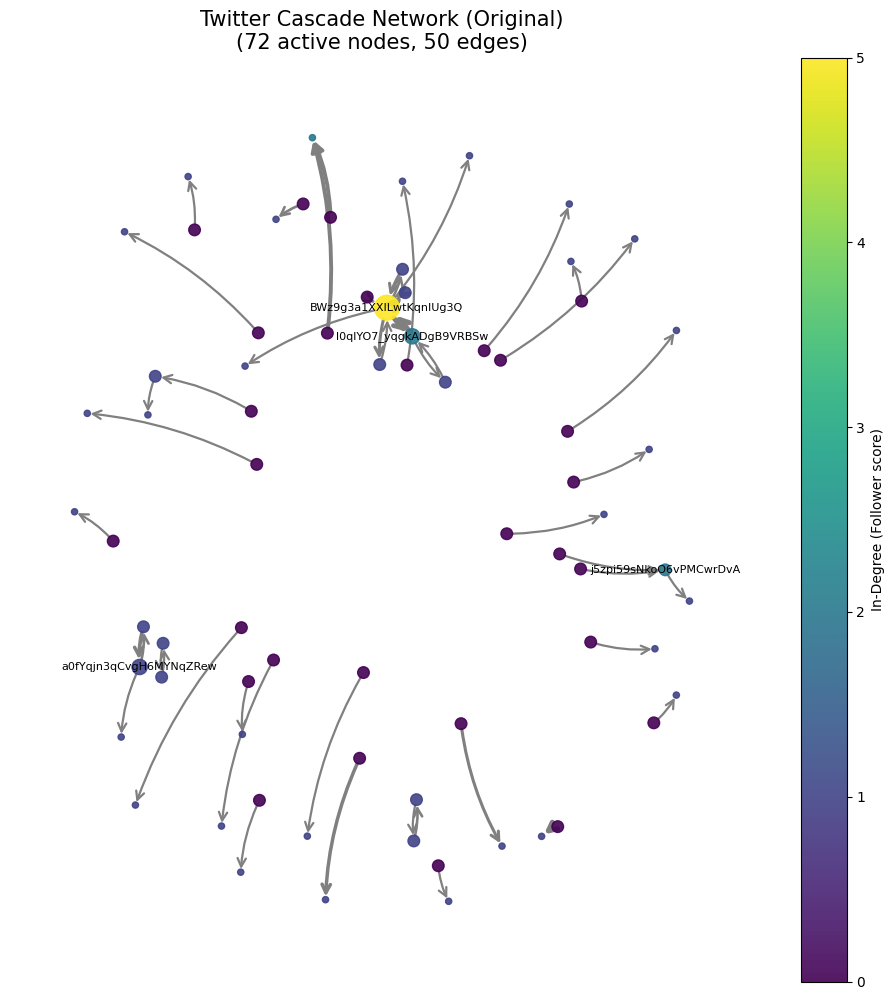

Affichage filtré (poids >= 2). Arêtes restantes : 19


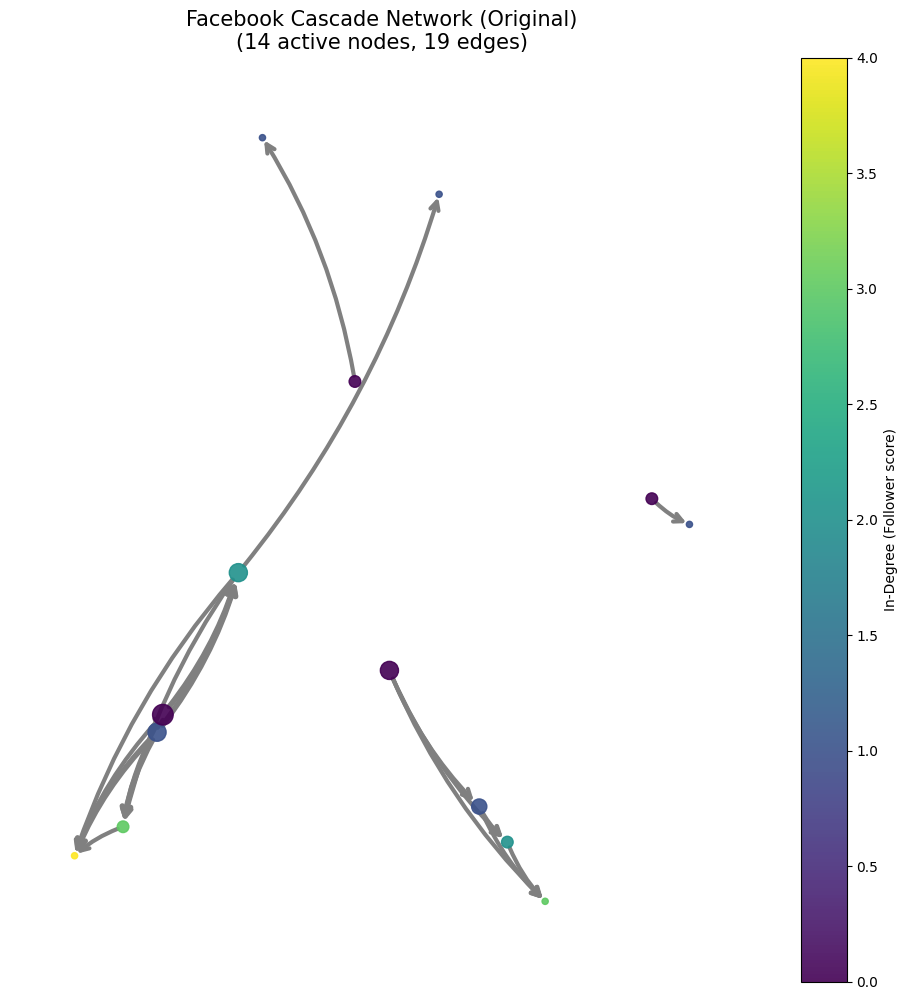

In [13]:
import numpy as np

def extract_cascade_network(df, time_threshold=52):
    """
    Génère un graphe dirigé (Cascade).
    Si User A poste à t, et User B poste la même vidéo à t+delta (delta < threshold),
    alors on crée une flèche A -> B.
    Les arêtes sont pondérées par le nombre d'occurrences.
    """
    print("Extraction du réseau de cascade (Dirigé)...")
    G = nx.DiGraph()
    
    # Préparation
    df['nodeTime'] = pd.to_datetime(df['nodeTime'])
    all_users = df['nodeUserID'].unique()
    G.add_nodes_from(all_users)
    
    grouped = df.groupby('videoID')
    
    # Dictionnaire pour compter les poids des arêtes : (source, target) -> count
    edge_weights = {}
    
    for video_id, group in grouped:
        if len(group) < 2:
            continue
            
        group = group.sort_values('nodeTime')
        users = group['nodeUserID'].tolist()
        times = group['nodeTime'].tolist()
        n = len(users)
        
        for i in range(n):
            for j in range(i + 1, n):
                delta = (times[j] - times[i]).total_seconds()
                
                if delta <= time_threshold:
                    source = users[i]
                    target = users[j]
                    
                    if source != target:
                        # On compte l'interaction
                        pair = (source, target)
                        if pair in edge_weights:
                            edge_weights[pair] += 1
                        else:
                            edge_weights[pair] = 1
                else:
                    break # Optimisation fenêtre glissante
    
    # Ajout des arêtes pondérées dans le graphe
    for (source, target), weight in edge_weights.items():
        G.add_edge(source, target, weight=weight)
        
    print(f"Cascade extraite : {G.number_of_nodes()} noeuds, {G.number_of_edges()} flèches.")
    return G

def plot_cascade_network(G, title="Cascade Network", min_weight=1):
    """
    Affiche le graphe de cascade.
    - Taille des noeuds proportionnelle au Out-Degree (Influenceurs).
    - Epaisseur des liens proportionnelle au Poids.
    - Filtre les liens faibles si min_weight > 1.
    """
    plt.figure(figsize=(12, 12))
    
    # 1. Filtrage (Optionnel : pour y voir plus clair)
    if min_weight > 1:
        edges_to_keep = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] >= min_weight]
        G_sub = G.edge_subgraph(edges_to_keep)
        # On garde quand même tous les noeuds connectés pour la structure
        print(f"Affichage filtré (poids >= {min_weight}). Arêtes restantes : {len(edges_to_keep)}")
    else:
        G_sub = G
        # On supprime les noeuds totalement isolés pour nettoyer le dessin
        G_sub = G_sub.subgraph([n for n in G_sub.nodes if G_sub.degree(n) > 0])

    if len(G_sub.nodes) == 0:
        print("Rien à afficher (graphe vide après filtrage).")
        return

    # 2. Layout (Disposition)
    # spring_layout est bon pour visualiser les clusters
    # k contrôle l'espacement (plus k est grand, plus les noeuds s'écartent)
    pos = nx.spring_layout(G_sub, k=0.15, iterations=20, seed=42)
    
    # 3. Calcul des attributs visuels
    # Taille basée sur le Out-Degree (ceux qui initient l'action)
    d = dict(G_sub.out_degree())
    node_sizes = [v * 50 + 20 for v in d.values()] # *50 pour agrandir l'effet
    
    # Couleurs basées sur le In-Degree (ceux qui suivent) vs Out-Degree
    node_colors = [G_sub.in_degree(n) for n in G_sub.nodes()]
    
    # Largeur des flèches basée sur le poids
    weights = [G_sub[u][v]['weight'] for u, v in G_sub.edges()]
    # Normalisation pour éviter des traits trop énormes
    if weights:
        max_w = max(weights)
        width_ratios = [1 + (w / max_w * 3) for w in weights]
    else:
        width_ratios = 1

    # 4. Dessin
    nodes = nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes, 
                                   node_color=node_colors, cmap=plt.cm.viridis, 
                                   alpha=0.9)
    
    edges = nx.draw_networkx_edges(G_sub, pos, node_size=node_sizes, 
                                   arrowstyle='->', arrowsize=15, 
                                   edge_color='gray', width=width_ratios, 
                                   connectionstyle='arc3,rad=0.1') # Courbure pour voir A->B et B->A
    
    # Labels (Seulement pour les gros noeuds pour ne pas surcharger)
    # On affiche l'ID si le noeud a un degré > moyenne
    avg_degree = np.mean([d for n, d in G_sub.degree()])
    labels = {n: n for n in G_sub.nodes() if G_sub.degree(n) > avg_degree * 2}
    nx.draw_networkx_labels(G_sub, pos, labels=labels, font_size=8, font_color='black')

    plt.title(f"{title}\n({G_sub.number_of_nodes()} active nodes, {G_sub.number_of_edges()} edges)", fontsize=15)
    plt.colorbar(nodes, label="In-Degree (Follower score)")
    plt.axis('off')
    plt.show()

def inspect_top_influencer(G, specific_node_id=None):
    """
    Isole et affiche le voisinage du noeud le plus important (ou d'un noeud spécifique).
    Affiche les poids sur les flèches pour comprendre l'intensité des liens.
    """
    # 1. Trouver le noeud cible
    if specific_node_id is None:
        # On cherche le noeud avec le plus gros Out-Degree (le plus influent)
        # Si le graphe n'est pas dirigé, on prend le Degree tout court
        if G.is_directed():
            degrees = dict(G.out_degree())
        else:
            degrees = dict(G.degree())
            
        target_node = max(degrees, key=degrees.get)
        print(f"Zoom sur le noeud le plus actif : {target_node} ({degrees[target_node]} connexions)")
    else:
        target_node = specific_node_id

    # 2. Extraire le 'Ego Graph' (Le noeud + ses voisins directs)
    # radius=1 signifie "juste les amis directs". radius=2 inclurait les "amis d'amis".
    ego_G = nx.ego_graph(G, target_node, radius=1)
    
    if len(ego_G) < 2:
        print("Ce noeud est isolé ou n'a pas de voisins.")
        return

    # 3. Affichage 'Zoomé'
    plt.figure(figsize=(10, 8))
    
    # Disposition en étoile (le chef au centre)
    pos = nx.spring_layout(ego_G, k=0.5, seed=42) 
    
    # Dessiner les noeuds
    # Le centre en ROUGE, les voisins en BLEU
    node_colors = ['red' if n == target_node else 'skyblue' for n in ego_G.nodes()]
    nx.draw_networkx_nodes(ego_G, pos, node_color=node_colors, node_size=800, alpha=0.9)
    
    # Dessiner les arêtes
    nx.draw_networkx_edges(ego_G, pos, arrowstyle='->', arrowsize=20, edge_color='gray')
    
    # Labels des noeuds (Noms des utilisateurs)
    nx.draw_networkx_labels(ego_G, pos, font_size=10, font_weight='bold')
    
    # Labels des arêtes (Les POIDS ! Très important pour voir la répétition)
    edge_labels = nx.get_edge_attributes(ego_G, 'weight')
    nx.draw_networkx_edge_labels(ego_G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title(f"Inspection locale du noeud : {target_node}", fontsize=15)
    plt.axis('off')
    plt.show()


df_twitter = pd.read_csv('original_data/twitter_cross_platform.csv', sep=',')
df_facebook = pd.read_csv('original_data/facebook_cross_platform.csv', sep=',')
    
# 1. Extraire la cascade
G_cascade_twitter = extract_cascade_network(df_twitter, time_threshold=120)
G_cascade_facebook = extract_cascade_network(df_facebook, time_threshold=120)


# 2. Afficher
# Pour Twitter, comme tu as ~250 arêtes, tu n'as pas besoin de filtrer (min_weight=1)
plot_cascade_network(G_cascade_twitter, title="Twitter Cascade Network (Original)", min_weight=2)

plot_cascade_network(G_cascade_facebook, title="Facebook Cascade Network (Original)", min_weight=2)